# Model 3 Transfer Learning
- ConvNeXtTiny

## Import necessary libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import PIL
from PIL import Image

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load all .jpeg and .jpg files

In [4]:
damask_rose = glob.glob("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/*.jpeg")
rain_lily = glob.glob("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Rain Lily/*.jpeg")
echeveria_flower = glob.glob("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Echeveria Flower/*.jpg")
mirabilis_jalapa = glob.glob("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Mirabilis Jalapa/*.jpg")
zinnia_elegans = glob.glob("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Zinnia Elegans/*.jpg")

total_drose = len(damask_rose)
total_rlily = len(rain_lily)
total_eflower = len(echeveria_flower)
total_mjalapa = len(mirabilis_jalapa)
total_zelegans = len(zinnia_elegans)

# Use 45% of images in each file
ImgFiles = damask_rose[:round(0.45*total_drose)] + rain_lily[:round(0.45*total_rlily)] + echeveria_flower[:round(0.45*total_eflower)] + mirabilis_jalapa[:round(0.45*total_mjalapa)] + zinnia_elegans[:round(0.45*total_zelegans)]

for items in ImgFiles[:5]:
    print(items)

print("The total number of img files : ", len(ImgFiles))
print("The total number of damask rose images: ", round(0.45*total_drose))
print("The total number of rain lily images: ", round(0.45*total_rlily))
print("The total number of echeveria flower images: ", round(0.45*total_eflower))
print("The total number of mirabilis jalapa images: ", round(0.45*total_mjalapa))
print("The total number of zinnia elegans images: ", round(0.45*total_zelegans))

/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/Damask Rose (123).jpeg
/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/Damask Rose (100).jpeg
/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/Damask Rose (115).jpeg
/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/Damask Rose (113).jpeg
/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Ornamental_Plants/Damask Rose/Damask Rose (107).jpeg
The total number of img files :  1079
The total number of damask rose images:  225
The total number of rain lily images:  224
The total number of echeveria flower images:  225
The total number of mirabilis jalapa images:  225
The total number of zinnia elegans images:  180


## Prepare the dataset and populate X and y

In [5]:
X = []
y = []

for fName in ImgFiles:

  X_i = Image.open(fName)
  X_i = X_i.resize((299,299))
  X_i = np.array(X_i) / 255.0

  X.append(X_i)

  label = fName.split('/')
  y_i = label[-2]

  y.append(y_i)

In [6]:
print(set(y)) # classes

print(len(X)) # Number of samples
print(len(y))

{'Damask Rose', 'Zinnia Elegans', 'Rain Lily', 'Echeveria Flower', 'Mirabilis Jalapa'}
1079
1079


In [7]:
# Transform y (classes) into integer values using label encoder

from sklearn.preprocessing import LabelEncoder

lEncoder = LabelEncoder()
y = lEncoder.fit_transform(y)

print(set(y))
print(lEncoder.classes_)

{0, 1, 2, 3, 4}
['Damask Rose' 'Echeveria Flower' 'Mirabilis Jalapa' 'Rain Lily'
 'Zinnia Elegans']


In [8]:
# Convert X and y to numpy arrays

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(1079, 299, 299, 3)
(1079,)


## Train - Test split (75-25)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=42)

print("X_train_shape: {}".format(X_train.shape))
print("X_test_shape: {}".format(X_test.shape))

X_train_shape: (809, 299, 299, 3)
X_test_shape: (270, 299, 299, 3)


In [10]:
# Standardizing X_train and X_test

mu = X_train.mean()
std = X_train.std()

X_train_std = (X_train-mu)/std
X_test_std = (X_test-mu)/std

### Total Number of images in the dataset = 1079

### Number of images present per class:
- Damask rose:  225
- Rain lily:  224
- Echeveria flower:  225
- Mirabilis jalapa:  225
- Zinnia elegans:  180

### Total number of images for Training and Testing:
- Training : 809
- Testing : 270

## Retrieve ConvNeXtTiny model and preparing the CNN model architecture

In [12]:
# Using InceptionResNetV2 model without classifier as base model
base_model = keras.applications.ConvNeXtTiny(
                model_name="convnext_tiny",
                include_top=False,
                weights="imagenet"
)

# Freeze the weights - will not be updated during backpropagation
for layer in base_model.layers:
  layer.trainable = False

# Adding classifier
global_pool = keras.layers.GlobalAveragePooling2D()(base_model.output)

x = keras.layers.Dropout(0.15)(global_pool)

output_ = keras.layers.Dense(units=5, activation='softmax')(x)

model3_TL = keras.models.Model(inputs=[base_model.input], outputs=[output_])

## Compile, fit and evaluate the model.
- Save the best weights

In [13]:
model3_TL.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

callbacks3_TL = [
             keras.callbacks.ModelCheckpoint("bestTL3.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)]

history3_TL = model3_TL.fit(x = X_train_std, y = y_train, epochs=10,
                          validation_split=0.1, batch_size=16, callbacks=callbacks3_TL)

Epoch 1/10
46/46 [==============================] - 37s 462ms/step - loss: 1.3088 - accuracy: 0.6099 - val_loss: 0.9394 - val_accuracy: 1.0000
Epoch 2/10
46/46 [==============================] - 10s 224ms/step - loss: 0.7761 - accuracy: 0.9492 - val_loss: 0.5757 - val_accuracy: 1.0000
Epoch 3/10
46/46 [==============================] - 10s 225ms/step - loss: 0.5031 - accuracy: 0.9794 - val_loss: 0.3859 - val_accuracy: 1.0000
Epoch 4/10
46/46 [==============================] - 11s 232ms/step - loss: 0.3603 - accuracy: 0.9931 - val_loss: 0.2801 - val_accuracy: 1.0000
Epoch 5/10
46/46 [==============================] - 10s 225ms/step - loss: 0.2723 - accuracy: 0.9931 - val_loss: 0.2171 - val_accuracy: 1.0000
Epoch 6/10
46/46 [==============================] - 11s 230ms/step - loss: 0.2153 - accuracy: 0.9945 - val_loss: 0.1710 - val_accuracy: 1.0000
Epoch 7/10
46/46 [==============================] - 11s 230ms/step - loss: 0.1736 - accuracy: 0.9973 - val_loss: 0.1418 - val_accuracy: 1.0000

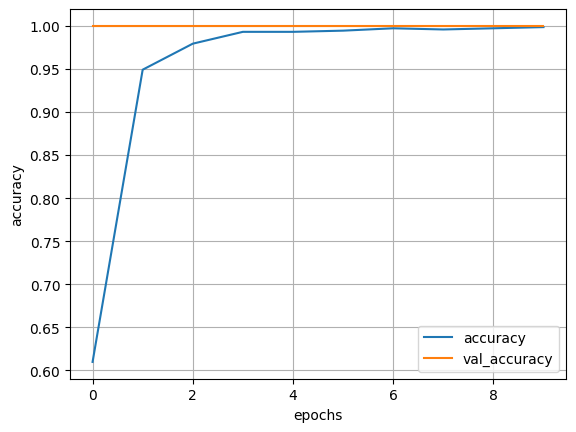

In [14]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history3_TL.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [15]:
testLoss_TL, testAccuracy_TL = model3_TL.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

9/9 [==============================] - 9s 691ms/step - loss: 0.1023 - accuracy: 1.0000
Test-loss: 0.102275, Test-accuracy: 1.000000


In [16]:
# Plugging best weights to the model to evaluate

model3_TL.load_weights("bestTL3.h5")

testLoss_TL, testAccuracy_TL = model3_TL.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_TL, testAccuracy_TL))

9/9 [==============================] - 3s 358ms/step - loss: 0.9465 - accuracy: 0.9926
Test-loss: 0.946503, Test-accuracy: 0.992593


## Prediction of testing sample and inferences

In [17]:
y_proba = model3_TL.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

9/9 [==============================] - 7s 355ms/step
[4 3 1 3 0 4 1 4 1 4 0 4 1 1 4 4 0 2 2 3 3 3 1 2 0 0 4 3 1 4 3 2 0 1 1 1 3
 3 1 0 0 0 1 0 0 3 1 1 4 3 0 2 3 0 2 3 4 0 1 0 3 3 0 2 0 0 3 2 4 3 3 2 4 2
 3 3 1 2 4 4 2 3 0 1 4 1 1 2 2 2 2 0 0 2 4 1 3 2 1 0 2 3 3 3 4 2 4 4 1 3 0
 2 4 3 1 0 3 2 1 0 1 3 1 1 1 0 2 2 1 0 4 2 2 2 1 1 1 2 0 2 1 1 1 4 3 0 0 2
 0 2 3 0 0 1 1 4 2 0 2 3 4 3 2 3 0 0 1 0 1 1 2 4 2 1 4 3 2 3 4 0 0 3 2 3 4
 0 3 2 3 4 3 0 3 3 0 2 0 3 3 0 3 2 1 1 3 0 2 4 0 0 4 0 3 4 1 2 2 3 1 2 3 4
 2 0 0 2 0 4 4 4 3 2 1 2 4 3 4 1 1 4 3 3 0 0 2 0 1 1 1 4 1 3 1 4 2 3 0 2 4
 2 1 0 2 4 2 1 4 0 1 0]


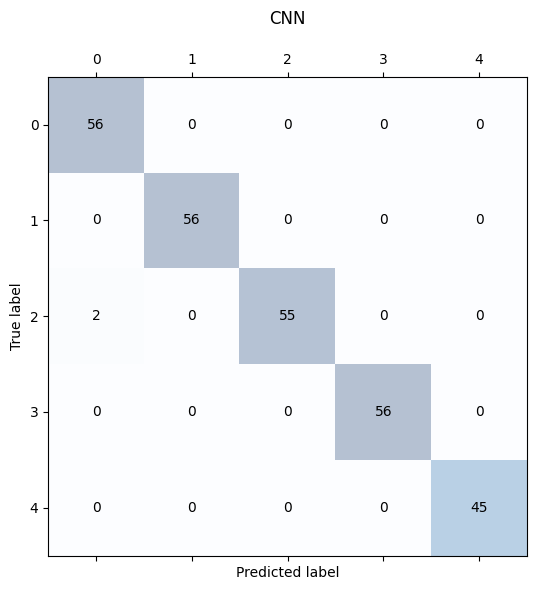

{0, 1, 2, 3, 4}
['Damask Rose' 'Echeveria Flower' 'Mirabilis Jalapa' 'Rain Lily'
 'Zinnia Elegans']


In [18]:
# Confusion matrix of testing data

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

print(set(y))
print(lEncoder.classes_)

In [19]:
# Calculating the precision, recall and f1 score

from sklearn.metrics import precision_score, recall_score, f1_score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

Precision:  0.9928480204342274
Recall:  0.9925925925925926
F1-score:  0.9925914322844147


## Save the final Transfer Learning model

In [21]:
model3_TL.save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/Model3_TL.h5")

In [23]:
from numpy import save

save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/X_train_std3.npy", X_train_std)
save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/X_test_std3.npy", X_test_std)

save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/y_train3.npy", y_train)
save("/content/drive/MyDrive/Abbinav's Portfolio/Transfer Learning CNN project/Models/y_test3.npy", y_test)